In [1]:
import matplotlib.pyplot as plt

from platform import python_version
from scipy import stats

import numpy as np
import scipy.io as sio
import pandas as pd
import sklearn
import matplotlib

import timeit
from tqdm import tqdm
import random
import os

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable

# import preprocessing tools 
from sklearn.model_selection import KFold
from sklearn.feature_selection import mutual_info_regression as mi
from sklearn.preprocessing import OrdinalEncoder, MinMaxScaler
from sklearn.metrics import r2_score

In [2]:
print("python version==%s" % python_version())
print("pandas==%s" % pd.__version__)
print("numpy==%s" % np.__version__)
print("sklearn==%s" % sklearn.__version__)
print("torch==%s" % torch.__version__)
print("matplotlib==%s" % matplotlib.__version__)

plt.rcParams[
    "figure.facecolor"
] = "w"  # force white background on plots when using dark mode in JupyterLab


if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

python version==3.8.3
pandas==1.0.5
numpy==1.18.5
sklearn==0.23.1
torch==1.7.0
matplotlib==3.2.2


In [3]:
print(os.listdir('DATA'))

train = pd.read_csv("DATA/train.csv").dropna(axis=1)
test = pd.read_csv("DATA/test.csv")

target = np.array(train['SalePrice'].values, np.float)

train.head()

['sample_submission.csv', 'test.csv', 'data_description.txt', 'house-prices-advanced-regression-techniques.zip', 'train.csv']


,Id,MSSubClass,MSZoning,LotArea,Street,LotShape,LandContour,Utilities,LotConfig,LandSlope,...,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,8450,Pave,Reg,Lvl,AllPub,Inside,Gtl,...,0,0,0,0,0,2,2008,WD,Normal,208500
1,2,20,RL,9600,Pave,Reg,Lvl,AllPub,FR2,Gtl,...,0,0,0,0,0,5,2007,WD,Normal,181500
2,3,60,RL,11250,Pave,IR1,Lvl,AllPub,Inside,Gtl,...,0,0,0,0,0,9,2008,WD,Normal,223500
3,4,70,RL,9550,Pave,IR1,Lvl,AllPub,Corner,Gtl,...,272,0,0,0,0,2,2006,WD,Abnorml,140000
4,5,60,RL,14260,Pave,IR1,Lvl,AllPub,FR2,Gtl,...,0,0,0,0,0,12,2008,WD,Normal,250000


# Preprocessing 

In [4]:
# pull out categorical and continuous features 
continuousfeatures = train.describe().columns.values[1:-1] 
categoricalfeatures = [ftr for ftr in train.columns.values[1:-1] if ftr not in continuousfeatures]
features = list(continuousfeatures) + categoricalfeatures

# Assume categorical features are ordinal and encode 
X_cat = train[categoricalfeatures].values
enc_X_cat = OrdinalEncoder().fit(X_cat).transform(X_cat)
train[categoricalfeatures] = enc_X_cat

# take decades since 2020 for features that describe the year 
yearfeatures = [f for f in features if 'Year' in f or 'Yr' in f]
train[yearfeatures] = (2020 - train[yearfeatures].values)/ 10

# take square root of features that describe area and divide by max 
areafeatures = [f for f in features if 'SF' in f or 'Area' in f]
train[areafeatures] = train[areafeatures].values**.5 / np.max(train[areafeatures].values**.5, 0)

# set up training data 
X = np.array(train[features].values, np.float)
y = np.array(train['SalePrice'].values, np.float)

# center data 
X = MinMaxScaler((-1, 1)).fit(X).transform(X)

# actually predict centered log_y 
y = np.log(y) - np.mean(np.log(y)) 

# set up a dataframe with features and target variables 
train[features] = X 
train['SalePrice'] = y
X_df = train[features]
y_df = train['SalePrice']

Create a dataset class for use with pytorch dataloader 

In [5]:
class Dataset(torch.utils.data.Dataset):
    def __init__(self, X_df, y_df):
        # set up dataframe
        self.X_df = X_df
        self.y_df = y_df
        

    def __getitem__(self, index):
        
        # load X 
        features = self.X_df.values[index]
        x = torch.tensor(features, dtype=torch.float32)
        
        # load noisey y 
        target = self.y_df.values[index]
        y = torch.tensor(target, dtype=torch.float32)

        return x, y
        
    def __len__(self):
        # total size of your dataset.
        return len(self.X_df)

# Define NN model 

In [6]:
class Model(nn.Module):
    
    def __init__(self, in_dim, h_dim, out_dim=1):
        super(Model, self).__init__()
        self.input_size  = in_dim
        self.hidden_size = h_dim
        self.output_size = out_dim
        
        # define first fully connected layer 
        self.fc1 = nn.Linear(self.input_size, self.hidden_size)
        
        # define optional second fully connected layer 
        self.fc2 = nn.Linear(self.hidden_size, self.hidden_size)
        
        # add activation 
        self.activation = nn.Sigmoid()
        
        # define fully connected hidden layer 
        self.output = nn.Linear(self.hidden_size, self.output_size)    
        
    def forward(self, out):
        out = self.fc1(out)
        out = self.activation(out)
        out = self.fc2(out)
        out = self.activation(out)
        out = self.output(out)
        return out

In [7]:
def NNtrain(model, loader, optimizer, criterion, num_epochs=30, verbose=True): 

    for epoch in range(num_epochs):

        # set up model for training     
        model.train()
        for i, (x, y) in enumerate(loader):

            # send data to gpu or cpu RAM 
            x = x.to(device)
            y = torch.reshape(y, [y.shape[0], 1])
            y = y.to(device)

            # Forward pass
            output = model(x)

            # Compute loss 
            loss = criterion(output, y) 
            # Backward pass
            loss.backward()       
            # Optimizer step
            optimizer.step()                        
            # Reset gradients   
            model.zero_grad()               

        if verbose and epoch%5==0:
            print ('Epoch [{}/{}], Loss: {:.3f}\n'
                .format(epoch+1, num_epochs, loss.detach().cpu().numpy()))
            
    return model

# Train model 

In [8]:
# set up out of fold predictions
oof = np.zeros(len(X_df))

# split data into 10 train+validation and testing data sets
skf1 = KFold(n_splits=5, shuffle=True, random_state=123)
skf1.get_n_splits(X_df, y_df)
for trainval_index, test_index in tqdm(skf1.split(X_df), desc="K-Fold"):
    # split the whole dataset into training+validation data and testing sets
    X_trainval, X_test = X_df.iloc[trainval_index], X_df.iloc[test_index]
    y_trainval, y_test = y_df.iloc[trainval_index], y_df.iloc[test_index]
    
    # initialize the data set 
    dataset = Dataset(X_trainval, y_trainval)                                              
    loader = torch.utils.data.DataLoader(dataset=dataset, batch_size=32) 

    # initialize model 
    model = Model(in_dim=len(features), h_dim=16, out_dim=1).to(device)

    # define lr and optimizer 
    optimizer = torch.optim.Adam(model.parameters(), lr=.001)
    criterion = torch.nn.MSELoss()
    
    ### train nn
    model = NNtrain(model, loader, optimizer, criterion, num_epochs=75, verbose=True)
    
    # make predictions 
    X_test = torch.tensor(X_test.values, dtype=torch.float32)
    y_pred_test = model(X_test).detach().cpu().numpy().flatten()
    
    # store predictions
    oof[test_index] = y_pred_test

K-Fold: 0it [00:00, ?it/s]

Epoch [1/75], Loss: 0.134

Epoch [6/75], Loss: 0.024

Epoch [11/75], Loss: 0.017

Epoch [16/75], Loss: 0.017

Epoch [21/75], Loss: 0.016

Epoch [26/75], Loss: 0.016

Epoch [31/75], Loss: 0.016

Epoch [36/75], Loss: 0.016

Epoch [41/75], Loss: 0.016

Epoch [46/75], Loss: 0.016

Epoch [51/75], Loss: 0.016

Epoch [56/75], Loss: 0.016

Epoch [61/75], Loss: 0.016

Epoch [66/75], Loss: 0.016

Epoch [71/75], Loss: 0.016



K-Fold: 1it [00:07,  7.43s/it]

Epoch [1/75], Loss: 0.117

Epoch [6/75], Loss: 0.021

Epoch [11/75], Loss: 0.013

Epoch [16/75], Loss: 0.013

Epoch [21/75], Loss: 0.013

Epoch [26/75], Loss: 0.013

Epoch [31/75], Loss: 0.013

Epoch [36/75], Loss: 0.013

Epoch [41/75], Loss: 0.013

Epoch [46/75], Loss: 0.013

Epoch [51/75], Loss: 0.012

Epoch [56/75], Loss: 0.012

Epoch [61/75], Loss: 0.012

Epoch [66/75], Loss: 0.012

Epoch [71/75], Loss: 0.012



K-Fold: 2it [00:12,  6.77s/it]

Epoch [1/75], Loss: 0.090

Epoch [6/75], Loss: 0.032

Epoch [11/75], Loss: 0.017

Epoch [16/75], Loss: 0.014

Epoch [21/75], Loss: 0.014

Epoch [26/75], Loss: 0.013

Epoch [31/75], Loss: 0.013

Epoch [36/75], Loss: 0.013

Epoch [41/75], Loss: 0.013

Epoch [46/75], Loss: 0.013

Epoch [51/75], Loss: 0.013

Epoch [56/75], Loss: 0.013

Epoch [61/75], Loss: 0.013

Epoch [66/75], Loss: 0.013

Epoch [71/75], Loss: 0.013



K-Fold: 3it [00:17,  6.24s/it]

Epoch [1/75], Loss: 0.108

Epoch [6/75], Loss: 0.017

Epoch [11/75], Loss: 0.010

Epoch [16/75], Loss: 0.011

Epoch [21/75], Loss: 0.011

Epoch [26/75], Loss: 0.011

Epoch [31/75], Loss: 0.011

Epoch [36/75], Loss: 0.010

Epoch [41/75], Loss: 0.010

Epoch [46/75], Loss: 0.010

Epoch [51/75], Loss: 0.010

Epoch [56/75], Loss: 0.009

Epoch [61/75], Loss: 0.009

Epoch [66/75], Loss: 0.009

Epoch [71/75], Loss: 0.009



K-Fold: 4it [00:22,  5.70s/it]

Epoch [1/75], Loss: 0.110

Epoch [6/75], Loss: 0.026

Epoch [11/75], Loss: 0.014

Epoch [16/75], Loss: 0.013

Epoch [21/75], Loss: 0.013

Epoch [26/75], Loss: 0.013

Epoch [31/75], Loss: 0.013

Epoch [36/75], Loss: 0.013

Epoch [41/75], Loss: 0.013

Epoch [46/75], Loss: 0.013

Epoch [51/75], Loss: 0.013

Epoch [56/75], Loss: 0.013

Epoch [61/75], Loss: 0.013

Epoch [66/75], Loss: 0.013

Epoch [71/75], Loss: 0.013



K-Fold: 5it [00:27,  5.46s/it]


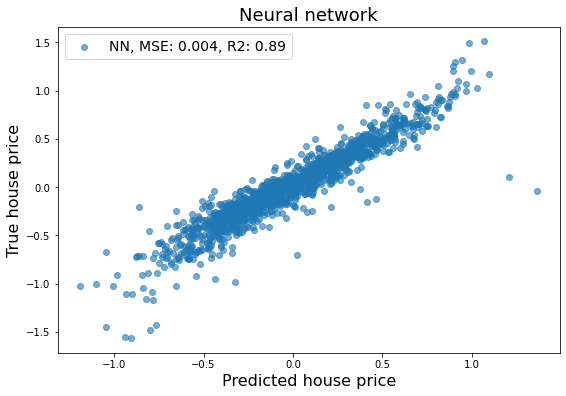

In [9]:
# calculate performance
mse = np.linalg.norm(y - oof)/len(y)
R2 = r2_score(y, oof)

plt.figure(figsize=(9, 6))

plt.scatter(oof, y, alpha=.6, label="NN, MSE: {:.3f}, R2: {:.2f}".format(mse, R2))
plt.xlabel("Predicted house price", fontsize=16)
plt.ylabel("True house price", fontsize=16)

plt.legend(fontsize=14)
plt.title("Neural network", fontsize=18)
plt.show()